## Hybrid Search

### Append required data to vector store
1. Preprocess Raw Text: Extract paragraphs from the raw text.
1. Identify Words: Use DPR tokenizer to get tokenized words.
1. Parse text naively to get all words (remove punctuation and diacritics, then split).
1. Find Untokenized Words:
    - Untokenized words = all words - tokenized words.
    - Add the top 3 most frequent untokenized words to each paragraph.
    - Add the top 3 most frequent article-level untokenized words to each paragraph.
1. Identify Capitalized Terms:
    - Find capitalized terms with 3 or more characters.
    - Add the top 3 most frequent capitalized terms to each paragraph.
    - Add the top 3 most frequent article-level capitalized terms to each paragraph.

### Query Workflow:

1. First filter results using untokenized words or capitalized terms.
2. Then proceed with dot-product embedding search.

In [ ]:
from pathlib import Path
from askem.preprocessing import HaystackPreprocessor
from transformers import DPRContextEncoderTokenizer
from typing import List, Optional
from pydantic import BaseModel
import hashlib
import unicodedata
import json


In [ ]:
TEST_DOCS = list(Path("data/covid1000").glob("*.txt"))[:100]
OUTPUT_DIR = Path("data/hybrid_retrieval/experiment_4")

preprocessor = HaystackPreprocessor()
tokenizer = DPRContextEncoderTokenizer.from_pretrained("facebook/dpr-ctx_encoder-single-nq-base")

Helper functions

In [ ]:

def strip_punctuation(text: str) -> str:
    return "".join([c for c in text if c.isalnum() or c.isspace()])

def remove_diacritics(text: str) -> str:
    nfkd_form = unicodedata.normalize('NFKD', text)
    return ''.join([c for c in nfkd_form if not unicodedata.combining(c)])

def get_non_tokenized_words(text, tokenizer, min_length = 3, top_k: int = 3) -> list:
    """Get words that are not tokenized by a tokenizer."""

    # Preprocess text
    text = strip_punctuation(text).lower()
    text = remove_diacritics(text)

    all_words = set(text.split())

    tokenized = tokenizer(text)["input_ids"]
    tokenized_words = set(tokenizer.decode(tokenized).split())

    non_tokenized_words = all_words - tokenized_words
    non_tokenized_words = [word for word in non_tokenized_words if len(word) >= min_length]

    if not non_tokenized_words:
        return None
    
    # Count the number of non-tokenized words
    counts = {word: text.count(word) for word in non_tokenized_words}
    
    return sorted(counts, key=counts.get, reverse=True)[:top_k]


def get_all_cap_words(text: str, min_length: int = 3, top_k: int = 3) -> list:
    """Get capitalized words in a text, sorted by number of occurrence."""

    text = strip_punctuation(text)
    text = remove_diacritics(text)
    
    words = text.split()
    all_cap_words = [word for word in words if word.isupper() and len(word) >= min_length]

    if not all_cap_words:
        return None
    
    # Count the number of all caps words
    counts = {word: text.count(word) for word in all_cap_words}

    # Return top-k most frequent all caps words
    return sorted(counts, key=counts.get, reverse=True)[:top_k]


How many fields are too many?

## To-Dos

1. What is the distribution of n CAP and n NON-TOKENIZED looks like?
2. Same as 1, but at article level.   

In [ ]:
class Paragraph(BaseModel):

    id: Optional[str] = None
    paper_id: str
    text: str
    non_tokenized_words: Optional[list] = None
    all_cap_words: Optional[list] = None

    # These are from parent article
    article_non_tokenized_words: Optional[list] = None
    article_all_cap_words: Optional[list] = None

    def __init__(self, **data) -> None:
        super().__init__(**data)
        self.id = hashlib.md5(self.text.encode()).hexdigest()

    def save(self, path: Optional[Path] = None) -> None:
        if not path:
            path = OUTPUT_DIR / f"{self.id}.json"
        path.parent.mkdir(parents=True, exist_ok=True)
        with open(path, "w") as f:
            f.write(self.json(indent=4))

Process all test documents

In [ ]:
CAPITALIZED_TERMS_COUNT = dict()
NON_TOKENIZED_TERMS_COUNT = dict()

def update_count(d: dict, words: Optional[List[str]]) -> None:
    if not words:
        return None
    
    for word in words:
        if word in d:
            d[word] += 1
        else:
            d[word] = 1


def get_top_k(d: dict, k: int = 10, min_n: int = 3) -> dict:
    """Get top-k most frequent words in a dictionary."""

    d = {k: v for k, v in d.items() if v >= min_n}
    return sorted(d, key=d.get, reverse=True)[:k]

for i, article in enumerate(TEST_DOCS):
    print(f"Processing {i}/100: {article}...")

    paragraphs = preprocessor.run(input_file=article, topic="covid", doc_type="paragraph")

    # Keep track of article-level information
    this_outputs = []
    this_article_non_tokenized_words_count = {}
    this_article_all_cap_words_count = {}

    for paragraph in paragraphs:
        text = paragraph["text_content"]
        non_tokenized_words = get_non_tokenized_words(text, tokenizer, top_k=3)
        # print(f"{non_tokenized_words=}")
        all_cap_words = get_all_cap_words(text, top_k=3)
        # print(f"{all_cap_words=}")

        this_outputs.append(
            Paragraph(
                paper_id = paragraph["paper_id"],
                text = text,
                non_tokenized_words = non_tokenized_words,
                all_cap_words = all_cap_words,
            )
        )

        if non_tokenized_words:
            update_count(this_article_non_tokenized_words_count, non_tokenized_words)
            update_count(NON_TOKENIZED_TERMS_COUNT, non_tokenized_words)

        if all_cap_words:
            update_count(this_article_all_cap_words_count, all_cap_words)
            update_count(CAPITALIZED_TERMS_COUNT, all_cap_words)

    this_article_non_tokenized_words = get_top_k(this_article_non_tokenized_words_count, k=10, min_n=3)
    print(this_article_non_tokenized_words)

    this_article_all_cap_words = get_top_k(this_article_all_cap_words_count, k=10, min_n=3)
    print(this_article_all_cap_words)

    # Append article-level information to each paragraph
    for output in this_outputs:
        output.article_non_tokenized_words = this_article_non_tokenized_words
        output.article_all_cap_words = this_article_all_cap_words
        output.save()




# 13m 30s for 1000 docs locally

In [ ]:
print(len(CAPITALIZED_TERMS_COUNT))
print(len(NON_TOKENIZED_TERMS_COUNT))

with open("capitalized.json", "w") as f:
    f.write(json.dumps(CAPITALIZED_TERMS_COUNT, indent=4))

with open("non_tokenized.json", "w") as f:
    f.write(json.dumps(NON_TOKENIZED_TERMS_COUNT, indent=4)) 

In [ ]:
# Top 100 NON_TOKENIZED_TERMS (in 1000 test docs)
top_100_nt_terms = sorted(NON_TOKENIZED_TERMS_COUNT, key=NON_TOKENIZED_TERMS_COUNT.get, reverse=True)[:100]
print(top_100_nt_terms)

- encoding issue > capturing unique search term
- the tokenizer have very high coverage
- maybe not a good option

In [ ]:
tokenizer.vocab_size

In [ ]:
# Top 100
print(sorted(CAPITALIZED_TERMS_COUNT, key=CAPITALIZED_TERMS_COUNT.get, reverse=True)[:100])

In [ ]:
# Bottom 100
print(sorted(CAPITALIZED_TERMS_COUNT, key=CAPITALIZED_TERMS_COUNT.get, reverse=False)[:100])

- CAPTERMS is somewhat closer to ASKEM use cases.

### How many CAP terms are there at the paragraph level?

In [3]:
from tqdm import tqdm
from pathlib import Path
import json
JSON_FILES = Path("data/hybrid_retrieval/experiment_4").glob("*.json")

n_terms_paragraph = []
n_terms_article = []
for file in tqdm(list(JSON_FILES)):
    with open(file) as f:
        data = json.load(f)

    n_para = data["all_cap_words"]
    if not n_para:
        n_para = 0
    else:
        n_para = len(data["all_cap_words"])

    n_article = data["article_all_cap_words"]
    if not n_article: 
        n_article = 0
    else:
        n_article = len(data["article_all_cap_words"])


    n_terms_paragraph.append(n_para)
    n_terms_article.append(n_article)

  0%|          | 0/3800 [00:00<?, ?it/s]

100%|██████████| 3800/3800 [01:13<00:00, 51.37it/s]


In [4]:
import numpy as np
np.mean(n_terms_paragraph)

1.5407894736842105

On average, each paragraph has 1.5 terms. We can probably use 3 terms (fields) per paragraph in the database.

In [5]:
np.mean(n_terms_article)

5.742894736842105

On average, each article has 27 terms. 

<AxesSubplot: title={'center': 'Number of capitalized terms in an article'}, ylabel='Frequency'>

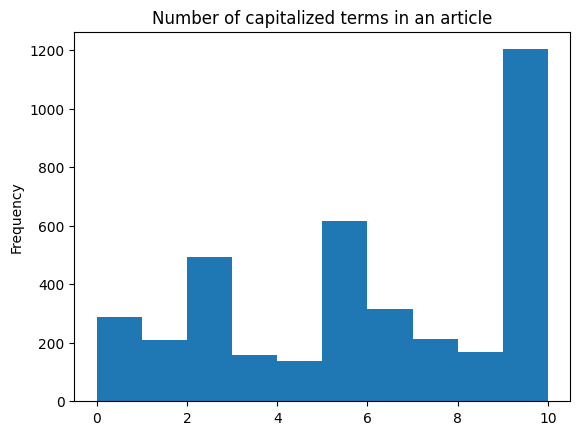

In [6]:
import pandas as pd

df = pd.DataFrame({"n_terms_paragraph": n_terms_paragraph, "n_terms_article": n_terms_article})
df['n_terms_article'].plot(kind="hist", title="Number of capitalized terms in an article")

Goal:
Select a specific number of terms at the article level to append to each paragraph for search optimization.

Considerations:

    Too Many Terms:
        Adding a lot of terms might slow down the search, although this needs to be verified through benchmarking.
        From a precision perspective, more terms are generally better.
        Possible Solution: Include terms that occur at least 3 times at the article level.

    Too Few Terms:
        A smaller number of terms could compromise search accuracy.

Initial Plan:

    Start by implementing 50 terms per paragraph as a baseline.
    Conduct benchmark tests to validate the effectiveness and speed of the search with this setting.